# Lab 1: Independent Component Analysis

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two people.
* The deadline is Thursday, April 19, 23:59.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [1]:
% pylab inline
import sys

assert sys.version_info[:3] >= (
3, 6, 0), "Make sure you have Python 3.6 installed"

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(
        float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1.,
                                                         phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d) #####change this function to randn to test with gaussian distribution
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()

    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)


Populating the interactive namespace from numpy and matplotlib


The following code generates some toy data to work with.

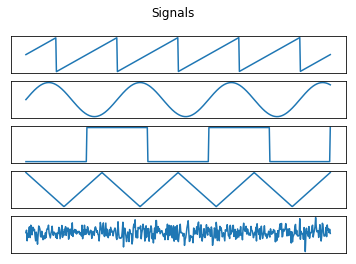

In [2]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [3]:
### 1.1 Make mixtures
def make_mixtures(S, A):
    # YOUR CODE HERE
    return np.dot(A, S)


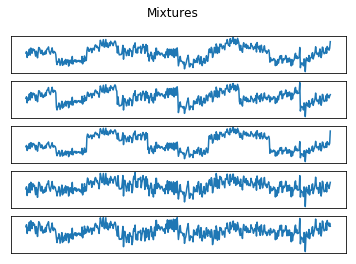

In [4]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

In [5]:
### 1.2 Histogram

import matplotlib.mlab as mlab
import math

def plot_histograms(X, title="Histogram"):
    mu = 0
    variance = 1
    sigma = math.sqrt(variance)
    x_ = np.linspace(mu - 2.5 * sigma, mu + 2.5 * sigma, 100)

    for index, x in enumerate(X):
        plt.subplot(1, len(X), index + 1)
        plt.hist(x)#, normed=True) # in order to compare with Gaussian distribution
        #plt.plot(x_, mlab.normpdf(x_, mu, sigma) , linewidth = 3) # in order to compare with Gaussian distribution
        
    plt.suptitle(title)

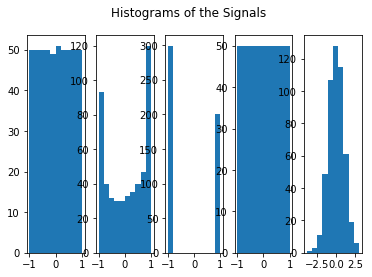

In [6]:
plot_histograms(S, "Histograms of the Signals")

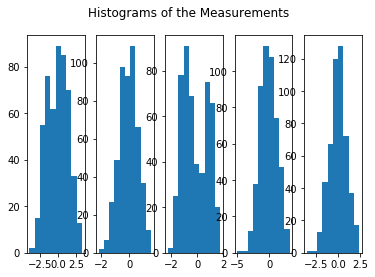

In [7]:
plot_histograms(X, "Histograms of the Measurements")

ADD THEORETICAL ANSWER


Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

YOUR ANSWER HERE  
The distributions of the measurements tend to look more like Gaussians. This is caused by (uniformly) randomly mixing the signals.
For the ICA it is important that the signals are non-Gaussian distributed in order to be able to separate them.


### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

YOUR ANSWER HERE

$$\phi(a) = \frac{d}{da} \ln p(a)$$  
therefore:  
$$p(a) \propto exp(\int \phi(a) da)$$  
  
This gives us:  
$$ p_0(a) \propto \frac{1}{cosh(a)} $$  
$$ p_1(a) \propto exp(\frac{-a^2}{2})~ cosh(a) $$  
$$ p_2(a) \propto exp(\frac{-a^4}{4})$$  
$$ p_3(a) \propto \frac{1}{(a^2 + 5)^3} $$


In [8]:
def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    # YOUR CODE HERE
    return 1 / np.cosh(a)


In [9]:
def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    # YOUR CODE HERE
    return np.exp(-0.5 * a ** 2) * np.cosh(a)


In [10]:
def phi_2(a):
    return -a ** 3

def p_2(a):
    # YOUR CODE HERE
    return np.exp(-0.25 * a ** 4)


In [11]:
import math

def phi_3(a):
    return -6 * a / (a ** 2 + 5)

def p_3(a):
    # YOUR CODE HERE
    # = exp( - integral(-6*a / (a**2 + 5)) ~> exp(-3 ln (a^2+5)) ~> (a^2+5)^(-3)
    return np.power((np.power(a, 2) + 5), -3)
    # return (a ** 2 + 5) ** (-3)


In [12]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000,), "Wrong output shape"


Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

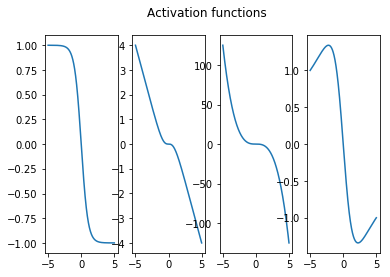

In [13]:
### 1.3 Implicit priors (continued)
a = np.linspace(-5, 5, 1000)

for index, funct in enumerate(activation_functions):
    plt.subplot(1, len(activation_functions), index + 1)
    plt.plot(a, funct(a))
    plt.suptitle('Activation functions')

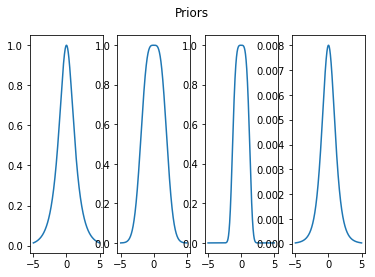

In [14]:
for index, funct in enumerate(priors):
    plt.subplot(1, len(priors), index + 1)
    plt.plot(a, funct(a))
    plt.suptitle('Priors')

### Answer to: Compare the shape of the priors to the histogram you plotted in the last question.  
We can see that all priors somewhat resemble the shape of a Gaussian distributions. Therefore, they are all similar to the shape of the histograms of the measurements, as we have identified them to be close to a Gaussian distribution as well. However, we notice that priors 1 and 2 show a broader peak, which is also visible in the aforementioned histograms. Therefore, we conclude, that they resemble the given measurements the best.

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

In [15]:
### 1.4 Whitening
def whiten(X):
    # normalize the mean to zero
    X -= np.mean(X, axis=1, keepdims=True)
    # calculate the covariance matrix
    Phi = np.cov(X)
    # calculate eigenvalues and eigenvalues
    Lambda, Phi = np.linalg.eigh(Phi)
    # set Lambda to have the eigenvalues on the diagonal
    Lambda = np.diag(Lambda)
    # calculate A
    A = Phi.dot(np.sqrt(np.linalg.inv(Lambda)))
    # get whitend data
    w = A.T.dot(X)
    return w


In [16]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.5 Interpret results of whitening (10 points)
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function. Describe what you see.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

In [17]:
### 1.5 Interpret results of whitening
def scatter_plot(signal):
    fig, axes = plt.subplots(len(signal), len(signal))
    
    for i, signal_1 in enumerate(signal):
        for j, signal_2 in enumerate(signal):
            
            axes[i][j].scatter(signal_1, signal_2, s = 0.2)


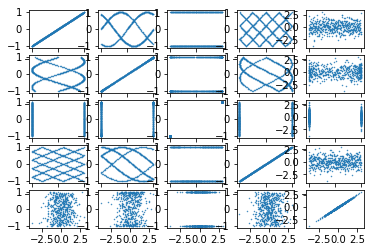

In [18]:
# plot signals

scatter_plot(S)

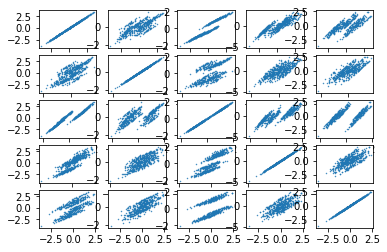

In [19]:
# plot measure
scatter_plot(X)

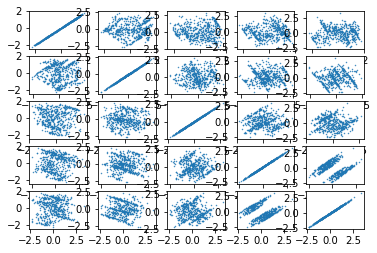

In [20]:
# plot whitend measure
scatter_plot(Xw)

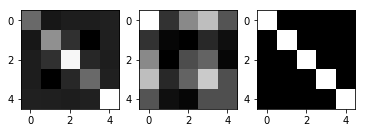

In [21]:
# plot the covariance matices

for index, conv in enumerate([np.cov(S), np.cov(X), np.cov(Xw)]):
    plt.subplot(1, 3, index + 1)
    imshow(conv, cmap='gray', interpolation='nearest')
    #print(conv)

Are the signals independent after whitening?

YOUR ANSWER HERE

No, they are decorrelated but not necessarily independent.

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

YOUR ANSWER HERE   

A covariant algorithm is a consistent algorithm that should give the same results independent of the units in which quantities are measured (Knuth, 1968).

If we look at the steepest descent rule, for example, we see that it is a non-covariant algorithm. Its update rule consists of a term of dimensions $[w_i]$ that is set equal to a term of dimensions $1/[w_i]$. This leads to the fact that this non-covariant algorithm needs a very large number of iterations to achieve convergence. 
In order to avoid this, we can adjust the update rule by multiplying the right-hand side with a matrix M of dimensions $[w_i, 1/w_i]$ in order to get the same dimensionality on both sides of the equation. This gives a covariant algorithm. M might be found by looking at the curvature of the objective function.

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [22]:
def ICA(X, activation_function, learning_rate=0.01, num_iterations = 10000):
    # YOUR CODE HERE
    # initialize W randomly
    W = random_nonsingular_matrix(d=len(X))

    # only loop over iterations
    for _ in range(num_iterations):
        # 1) Put x through a linear mapping:
        a = W @ X
        # 2) Put a through a nonlinear map:
        z = activation_function(a)
        # 3) Put a back through W:
        x_ = W.T @ a
        # calculate gradient
        grad = W + z @ x_.T / X.shape[1]
        # check for convergence
        if np.linalg.norm(grad) < 1e-5:
            #print(np.linalg.norm(grad))
            break
        # 4) Adjust the weights in accordance with
        W += learning_rate * grad
    return W

W_est = ICA(Xw, phi_3)  # Compare with ICA(X)

## Testing different learning rates, we found that the value 0.01 works the best. 
## With higher values we experience numerical overflow in the square of phi_3.

## We found that initializing W with a uniform distribution (using numpy.random.rand and learning rate 0.01)
## works better than when using a Gaussian distribution (using numpy.random.randn and learning rate 0.001). 

In [23]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])


### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$ (or reuse `W_estimates`). Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

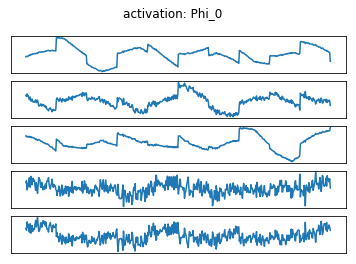

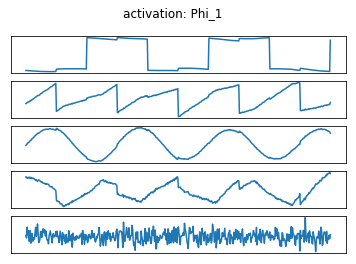

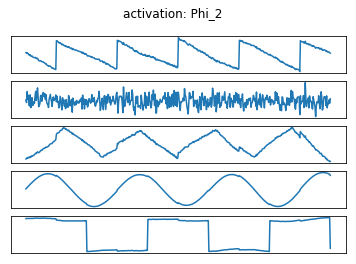

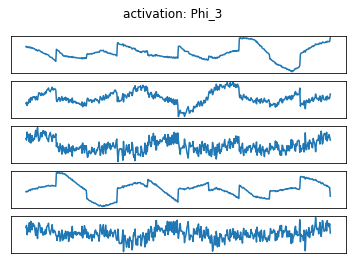

In [24]:
# 1.8 Experiments
def plot_results(W_estimates, X):
  for index, W in enumerate(W_estimates):
      plot_signals(W @ X, 'activation: Phi_{}'.format(index))
      
plot_results(W_estimates, Xw)

In [ ]:
import time

def does_whitening_make_a_difference():
    # Does it make a difference (in terms of speed of convergence) 
    # if you whiten your data before running ICA?

    # Return True or False
    # YOUR CODE HERE
    t0_w = time.time()
    ## increasing the number of possible iterations to enable convergence and get meaningful results
    W_estimates_w = [ICA(Xw, activation_function=phi,num_iterations=100000) for phi in activation_functions]
    t1_w = time.time()

    t0 = time.time()
    W_estimates = [ICA(X, activation_function=phi, num_iterations=100000) for phi in activation_functions]
    t1 = time.time()

    time_whitened = t1_w - t0_w
    time_non_whitened = t1 - t0
    print('time (sec) using whitened data: ', time_whitened)
    print('time (sec) using the original data: ', time_non_whitened)
    print('')
    
    if time_non_whitened / time_whitened > 1.2:
      print('Whitening does make a difference.')
      return True
    else:
      print('Whitening does not make a difference.')
      return False


In [ ]:
assert type(does_whitening_make_a_difference()) == bool

### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [ ]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown

# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

In [ ]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']

wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
# play_signals(S_audio, sample_rate)

In [ ]:
### 1.9 Audio demixing
X_mix = make_mixtures(S_audio, random_nonsingular_matrix(d=len(S)))

# whiten data
X_mix_w = whiten(X_mix)

# find W estimates with different phi and plot results
W_estimates_audio = [ICA(X_mix_w, activation_function=phi) for phi in activation_functions]

In [ ]:
plot_signals(X_mix, 'Generated mixture')

In [ ]:
plot_histograms(X_mix, 'Histogram of mixed audio signals')

plot_results(W_estimates_audio, X_mix_w)

reconstructed_S = W_estimates_audio @ X_mix_w
play_signals(reconstructed_S[3], sample_rate)

Report your results. Using which activation functions ICA recovers the sources?

YOUR ANSWER HERE  
Again, we can see that the mixed signals take a form that is close to that of a Gaussian distribution.
Both by examining the plots above and listening to the results, we can conclude that the activation functions 0 and 3 manage to separate the mixed signals into the original signals the best.

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).

To calculate the moments we first need the mean and the prior. For the mean we see that all priors are zero-centered and therefore we have a mean of 0. Using the results obtained in the exercises above we can get the kurtosis as follows:

Case 1:
\begin{align}
p(a) & = \frac{1}{\pi cosh(a)}\\
\mathbb{E}[X^4] &= \int \frac{1}{\pi cosh(a)}x^4 dx\\
& = \frac{5\pi^4}{16}\\
\mathbb{E}[X^2]^2 &= \left[\int \frac{1}{\pi cosh(a)}x^2  dx\right]^2 \\
& = \frac{\pi^4}{16}\\
Kurt[X] &= \frac{\frac{5\pi^4}{16}}{\frac{\pi^4}{16}}-3\\
& = 2
\end{align}

Case 2:
\begin{align}
p(a) & = \frac{1}{\sqrt{2\pi e}}exp\left(\frac{-a^2}{2}\right)cosh(a)\\
\mathbb{E}[X^4] &= \int \frac{1}{\sqrt{2\pi e}}exp\left(\frac{-a^2}{2}\right)cosh(a)  x^4 dx\\
& = 10 \frac{\sqrt{2\pi e}}{\sqrt{2\pi e}}\\
\mathbb{E}[X^2]^2 &= \left[\int \frac{1}{\sqrt{2\pi e}}exp\left(\frac{-a^2}{2}\right)cosh(a)  x^2 dx\right]^2 \\
& = \left(2\frac{\sqrt{2\pi e}}{\sqrt{2\pi e}}\right)^2\\
Kurt[X] &= \frac{ 10 \frac{\sqrt{2\pi e}}{\sqrt{2\pi e}}}{\left(2\frac{\sqrt{2\pi e}}{\sqrt{2\pi e}}\right)^2}-3\\
&=-0.5
\end{align}


Case 3:
\begin{align}
p(a) & = \frac{\sqrt{2}}{\Gamma(0.25)}exp\left(-\frac{x^4}{4}\right)\\
\mathbb{E}[X^4] &= \int \frac{\sqrt{2}}{\Gamma(0.25)}exp\left(-\frac{x^4}{4}\right) x^4 dx\\
& =  \frac{\sqrt{2}}{\Gamma(0.25)}\frac{\Gamma(0.25)}{\sqrt{2}}\\
\mathbb{E}[X^2]^2 &= \left[\int \frac{\sqrt{2}}{\Gamma(0.25)}exp\left(-\frac{x^4}{4}\right)  x^2 dx\right]^2 \\
& =  \frac{2}{\Gamma^2(0.25)}\left( \sqrt{2} \Gamma(3/4)\right)^2\\
Kurt[X] &= \frac{\frac{\sqrt{2}}{\Gamma(0.25)}\frac{\Gamma(0.25)}{\sqrt{2}}}{\frac{2}{\Gamma^2(0.25)}\left( \sqrt{2} \Gamma(3/4)\right)^2} -3\\
&=\frac{1}{\frac{4\Gamma^2(3/4)}{\Gamma^2(1/4)}}-3\\
&=\frac{\Gamma^2(1/4)}{4\Gamma^2(3/4)}-3\\
&\approx -0.811
\end{align}

Case 4:
\begin{align}
p(a) & = \frac{3\pi}{200\sqrt{5}}(a^2+5)^{-3}\\
\mathbb{E}[X^4] &= \int \frac{3\pi}{200\sqrt{5}}(x^2+5)^{-3} x^4 dx\\
\mathbb{E}[X^2]^2 &= \left[\int \frac{3\pi}{200\sqrt{5}}(a^2+5)^{-3}  x^2 dx\right]^2 \\
Kurt[X] &= \frac{\int \frac{3\pi}{200\sqrt{5}}(x^2+5)^{-3} x^4 dx}{\left[\int \frac{3\pi}{200\sqrt{5}}(a^2+5)^{-3}  x^2 dx\right]^2}-3\\
&= 6
\end{align}

In [ ]:
### Include your answer here (you can use math.gamma if needed)
def get_kurtosis():
    # Return a list with 4 numbers / expressions
    # return [0, 0, 0, 0]

    k1 = [
        2,
        -0.5,
        np.power(math.gamma(1/4), 2)/(np.power(math.gamma(3/4), 2) * 4) - 3,
        6
    ]

    return k1

In [ ]:
# Let's check
kurtosis = get_kurtosis()
print (kurtosis)
assert len(kurtosis) == 4

#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

In [ ]:
### 1.10.2 Excess Kurtosis
# YOUR CODE HERE

import scipy.stats

def get_kurtosis_empirical():
    # theoretical benchmark
    
    #k1 = get_kurtosis()
    #print('Analytical Kurtosis: {}\n\n'.format(k1))

    k2 = scipy.stats.kurtosis(S_audio, axis=1, fisher=True)
    k3 = scipy.stats.kurtosis(reconstructed_S, axis=2, fisher=True)
    k4 = scipy.stats.kurtosis(X, axis=1, fisher=True)
    reconstructed_X = W_estimates @ Xw
    k5 = scipy.stats.kurtosis(reconstructed_X, axis=2, fisher=True)

    l = ['original audio', 'reconstructed audio (activation functions 0 to 3)', 'original synthetic data', 'reconstructed synthetic data (activation functions 0 to 3)']

    for index, k in enumerate([k2, k3, k4, k5]):
        print('Kurtosis of {}:\n {}\n'.format(l[index], k))

get_kurtosis_empirical()


YOUR ANSWER HERE

Yes, we can.

In general, the kurtosis is a measure for outlayers: values around the mean are not relevant and do not contribute to the overall value of the kurtosis. Therefore, it is a measure of outlayers / the tails. 

From the empirical kurtosis values, we can draw the same conclusions about the performances of the different activation functions as seen above. For the synthetic data, we see that the activation functions 0 and 3 both return kurtosis values that are all close to zero. The activation functions 1 and 2, that also showed the best separation of the mixed signals as shown in the plots above, manage to get kurtosis value similar to the original data. Note, that the values are scrambled, but it is possible to find all the corresponding kurtosis values in the reconstructed data.

Comparing the kurtosis values for the different activation functions when applying them to the actual audio files, we find that again they match our previous observation that the function 0 and 3 manage to reconstruct the original signal the best. Even though they are scrambled, activation function 0 and 3 show very similar kurtosis values as the original audio, while functions 1 and 2 show numbers close to zero.